# Imports

In [1]:
import pynq
import time
from pynq import PL
import xrfclk
import xrfdc
import numpy as np
# from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.daccomb as daccomb
import mkidgen3
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc

# Load the Overlay and Setup RFDC and MIG

In [2]:
#ol = pynq.Overlay('../Full_Channelizer/rst_jenny/full_chan_cap_nec_rst_two_intrcnt.bit', ignore_version=True)
ol = pynq.Overlay('RFDC_Cap_Full_Rate.bit', ignore_version=True)

#ol.download()
#print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
#      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

In [3]:
dacreplay = ol.dac_table_axim_0

# Setup RFDC and MIG

In [4]:
g3._gen3_overlay=ol
xrfclk.set_ref_clks()
#ol.rfdc.start_clocks()
#ol.rfdc.rfdc_status(tell=True)
#print(f'Active ADC pair: {ol.rfdc.active_adc}')

## Setup DAC REPLAY

In [5]:
tones = np.array([0.3e9])
amplitudes = np.array([1.0])

In [6]:
dactable = generate_dac_comb(frequencies=tones, n_samples=2**19, sample_rate=4.096e9, amplitudes=amplitudes)
#{'iq': iq, 'frequencies': quantized_freqs, 'phases': phases}
qtones = dactable['frequencies']
qphases = dactable['phases']

In [7]:
dactable['iq'].real = 0

In [8]:
dacreplay.stop()

In [9]:
dacreplay.replay(dactable['iq'], fpgen=lambda x: (x*2**15).astype(np.uint16))

In [10]:
#dacreplay.quiet()

### Take ADC Snap

In [11]:
cap_result=ol.capture.capture_adc(2**19)

In [12]:
adc_capture_data = cap_result[:,0]/2**15 + 1j*cap_result[:,1]/2**15

In [13]:
cap_result.freebuffer()

# Plot Captured Data

In [15]:
N = 2**19
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)
time = np.linspace(0,Tc,N) # Time vector (seconds)
plot_start=16
plot_stop=20*4096+16
sl = slice(plot_start,plot_stop)
fft_freqs = np.linspace(-2.048e9,2.048e9,plot_stop-plot_start)

## Captured Time Series

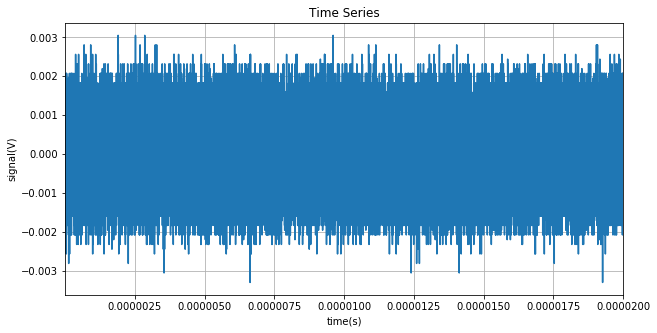

In [16]:
plt.figure(figsize=(10,5))
# plt.plot(time[sl],(ps_buf&0xffff)[sl].astype(np.int16), '-', label='real')
plt.plot(time[sl],adc_capture_data.real[sl])
plt.grid(True)
plt.xlabel("time(s)",position=(0.5,1))
plt.ylabel("signal(V)",position=(0,0.5))
ax = plt.gca()
ax.set_xlim(time[plot_start],time[plot_stop])
#plt.legend()
plt.title('Time Series')
plt.show()

## Captured FFT

In [17]:
y_fft = 20*np.log10(np.abs(fftshift(fft(adc_capture_data[sl]))))         # Calculate the FFT, and also shift so that f=0Hz is in the center.

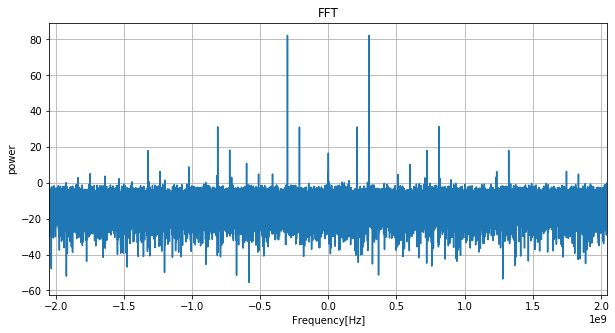

In [18]:
plt.figure(figsize=(10,5))
plt.plot(fft_freqs[::2],y_fft[::2]) # Note: the 2./N properly normalizes the FFT amplitude to be in Volts.
plt.grid(True)
ax = plt.gca()
#plt.yscale("log")      # Uncomment these to get a log-y scale.
#ax.set_ylim(1e-2,10)
ax.set_xlim(-2.048e9,2.048e9)
#ax.set_xlim(0.4e9, 0.6e9)
plt.xlabel("Frequency[Hz]",position=(0.5,0.5))
plt.ylabel("power",position=(1,0.5))
plt.title('FFT')
#plt.axvline(fft_freqs[np.argmax(y_fft)],color='k')
#plt.axvline(0.383e9,color='r')
#plt.axvline(-0.373e9,color='c')
plt.show()